# Which genes are turned on/off in some cancers but not others?

In [1]:
import NotebookImport
from DX_screen import *
from Figures.Regression import *

importing IPython notebook from DX_screen

importing IPython notebook from Imports

importing IPython notebook from Setup/DX_Imports

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


In [2]:
def dx_group(split, matched_tn, fc=1.):
    tab_1 = binomial_test_screen(matched_tn.ix[:, ti(split==True)], fc=fc)
    tab_1 = tab_1.ix[(((tab_1.frac - .5).abs() > .25) & (tab_1.p > .001)) == False]
    
    tab_0 = binomial_test_screen(matched_tn.ix[:, ti(split==False)], fc=fc)
    tab_0 = tab_0.ix[(((tab_0.frac - .5).abs() > .25) & (tab_0.p > .001)) == False]
    
    df = matched_tn.ix[:, ti(split==True)]
    ttest_1 = df.apply(ttest_rel, axis=1)
    
    df = matched_tn.ix[:, ti(split==False)]
    ttest_0 = df.apply(ttest_rel, axis=1)
    
    t0 = pd.concat([tab_0, ttest_0], keys=['binom','ttest'], axis=1)
    t1 = pd.concat([tab_1, ttest_1], keys=['binom','ttest'], axis=1)
    t = pd.concat([t0, t1], keys=['miss','hit'], axis=1)
    return t

#TP53

In [3]:
mut_all = pd.read_csv('/cellar/users/agross/TCGA_Code/TCGA/Data/MAFs_new_2/meta.csv', 
                      index_col=[1,2])
mut = mut_all['0'].unstack().fillna(0)
mut = FH.fix_barcode_columns(mut)
mut = mut.xs('01', axis=1, level=1)

In [4]:
maf = pd.read_csv('/cellar/users/agross/TCGA_Code/TCGA/Data/MAFs_new_2/mega_maf.csv', 
                      index_col=[1,2])

/cellar/users/agross/anaconda2/lib/python2.7/site-packages/pandas/io/parsers.py:1130: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [11]:
p53_mm = maf.ix['TP53'].Protein_Change

In [16]:
import re as re
get_nums = lambda s: re.findall(r'\d+', s)[0]

In [23]:
residue = p53_mm.dropna().apply(get_nums)
residue.index = residue.index.map(lambda s: s[:12])

In [30]:
residue.value_counts().head(30)

273    151
248    119
175     57
245     53
213     47
179     41
125     40
282     40
220     37
193     35
249     34
196     33
158     32
331     28
280     27
176     27
266     23
241     23
163     22
238     22
275     21
285     21
278     21
126     21
157     20
152     20
151     20
286     19
337     19
306     19
dtype: int64

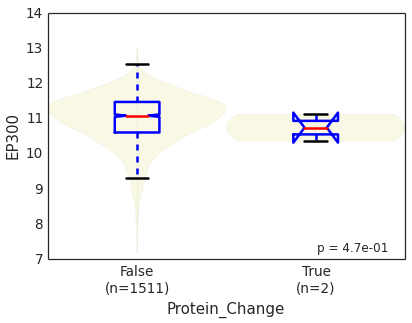

In [59]:
violin_plot_pandas(residue == '27', rna_df.ix['EP300'][:,'01'])

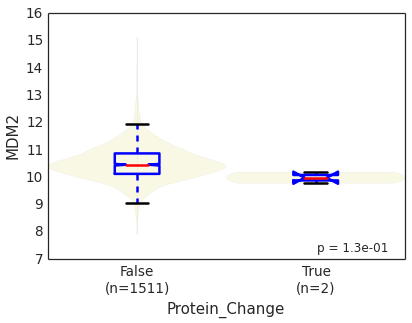

In [42]:
violin_plot_pandas(residue == '27', rna_df.ix['MDM2'][:,'01'])

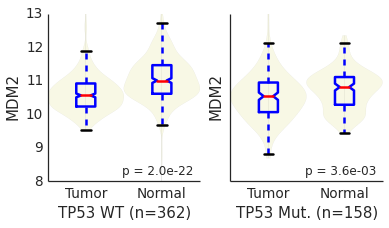

In [25]:
fig, axs = subplots(1,2,figsize=(6,3), sharey=True)
violin_plot_series(matched_tn.ix['MDM2'].ix[ti(mut.ix['TP53']==0)], ax=axs[0])
violin_plot_series(matched_tn.ix['MDM2'].ix[ti(mut.ix['TP53']>0)], ax=axs[1])
for ax in axs:
    prettify_ax(ax)
    ax.set_ybound(8,13)
    ax.set_xticklabels(['Tumor','Normal'])
axs[0].set_xlabel('TP53 WT (n=362)')
axs[1].set_xlabel('TP53 Mut. (n=158)')

In [16]:
def paired_bp_tn_split(vec, assignment, ax=None, split_vals=('01', '11'),
                       data_type='gene expression', order=None):
    """
    Paired boxplot for a single Series, with splitting on the index,
    grouped by assignment. I.E. Tumor-Normal gene expression split by
    cancer.
    
    vec: 
        vector of values to plot.
    assignment: 
        vector mapping keys to group assignment
    ax (None):
        matplotlib axis to plot on or None
    split_vals ('01','11'):
        Values to split the boxplot pairing on. The default of 
        ('01','11') indicates tumor vs. normal in the standard 
        TCGA barcode nomenclature.  This should coorespond to values
        on the second level of the index for vec and assignment.
        
    **both vec and assignment should have an overlapping index with
    multiple levels**
    """
    _, ax = init_ax(ax, figsize=(8, 3))
    if vec.name != None:
        label = vec.name  # lose label in manipulation
    else:
        label = ''
    g1 = split_vals[0]
    g2 = split_vals[1]
    vec = pd.concat([vec[:, g1], vec[:, g2]], keys=[g1, g2],
                    axis=1)
    vec = vec.dropna().stack()

    counts = vec.unstack().groupby(assignment).size()
    if order is None:
        groups = list(true_index(counts > 5))
        groups = vec.unstack().groupby(assignment).median()[g1].ix[groups]
        groups = groups.order().index[::-1]
    else:
        groups = order

    l1 = [np.array(vec[:, g1].ix[true_index(assignment == c)].dropna())
          for c in groups]
    l2 = [np.array(vec[:, g2].ix[true_index(assignment == c)].dropna())
          for c in groups]
    boxes = [x for t in zip(l1, l2) for x in t if len(t[1]) > 5]

    ax, bp = paired_boxplot(boxes, ax)
    labels = ['{}\n({})'.format(c, counts[c]) for c in groups]
    ax.set_xticklabels(labels)
    prettify_ax(ax)
    ax.set_ylabel('{} {}'.format(label, data_type))

In [17]:
d = pd.concat([codes, (mut.ix['TP53']>0).map({True: 'mut', False:'wt'})], axis=1).dropna()
d = d.ix[matched_rna.columns.get_level_values(0).unique()].dropna()
d = d.apply(lambda s: s.ix[0] + '\n' + s.ix[1], 1)
o = matched_rna.ix['EDA2R'][:,'11'].groupby(codes).mean().order().index
o = [v for c in o for v in [c + '\nwt', c + '\nmut'] if v in list(d)]

In [18]:
len(cancers)

27

In [19]:
p53_mut = (mut.ix['TP53']>0).map({True: 'mut', False:'wt'})
pt = matched_rna.columns.get_level_values(0).unique()
ct = pd.crosstab(codes.ix[pt], p53_mut)
cc = ti(ct.min(1) > 10)
len(cc)

6

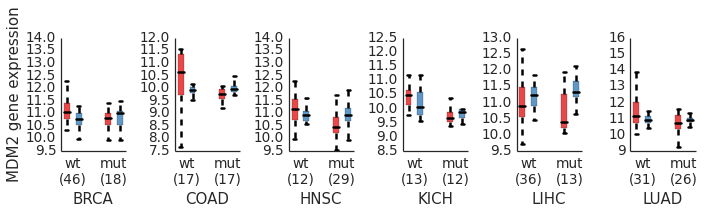

In [20]:
fig, axs = subplots(1,6, figsize=(10,3), sharey=False)
for i,c in enumerate(cc):
    ax = axs[i]
    paired_bp_tn_split(matched_rna.ix['MDM2'].ix[ti(codes==c)], p53_mut, ax=ax)
    if i > 0:
        ax.set_ylabel('')
    ax.set_xlabel(c)
fig.tight_layout()

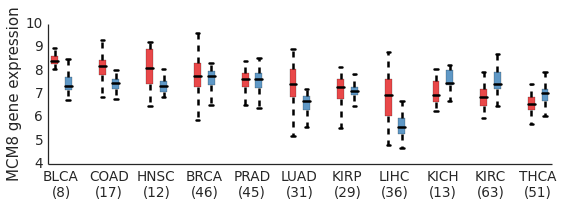

In [21]:
paired_bp_tn_split(matched_rna.ix['MCM8'].ix[ti(mut.ix['TP53']==0)], codes)

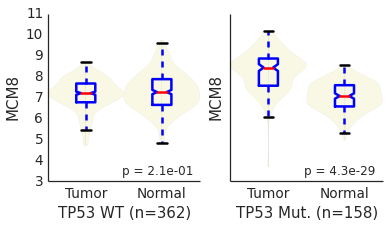

In [22]:
fig, axs = subplots(1,2,figsize=(6,3), sharey=True)
violin_plot_series(matched_rna.ix['MCM8'].ix[ti(mut.ix['TP53']==0)], ax=axs[0])
violin_plot_series(matched_rna.ix['MCM8'].ix[ti(mut.ix['TP53']>0)], ax=axs[1])
for ax in axs:
    prettify_ax(ax)
    ax.set_xticklabels(['Tumor','Normal'])
axs[0].set_xlabel('TP53 WT (n=362)')
axs[1].set_xlabel('TP53 Mut. (n=158)')

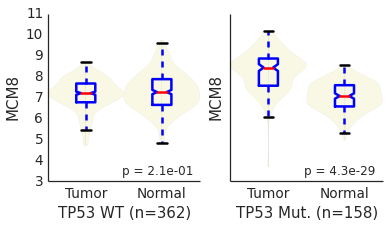

In [23]:
fig, axs = subplots(1,2,figsize=(6,3), sharey=True)
violin_plot_series(matched_rna.ix['MCM8'].ix[ti(mut.ix['TP53']==0)], ax=axs[0])
violin_plot_series(matched_rna.ix['MCM8'].ix[ti(mut.ix['TP53']>0)], ax=axs[1])
for ax in axs:
    prettify_ax(ax)
    ax.set_xticklabels(['Tumor','Normal'])
axs[0].set_xlabel('TP53 WT (n=362)')
axs[1].set_xlabel('TP53 Mut. (n=158)')

In [24]:
p53_dx.ix['EDA2R']

miss  binom  num_ox               206
             num_dx               323
             frac               0.638
             p               8.38e-07
      ttest  p               4.22e-13
             t          7.52563113172
hit   binom  num_ox                19
             num_dx               139
             frac               0.137
             p               4.01e-19
      ttest  p               3.76e-21
             t         -10.9727518238
Name: EDA2R, dtype: object

In [25]:
dr = (matched_rna.xs('01',1,1) > matched_rna.xs('11',1,1)) * 1.
dr = dr.ix[ti(dx_rna.num_dx > 200)].dropna()
cc = mut.ix['TP53']>0
odds_ratio, df_odds_ratio = odds_ratio_df(dr, cc)
log_odds = np.log2(odds_ratio).clip(-8,8)

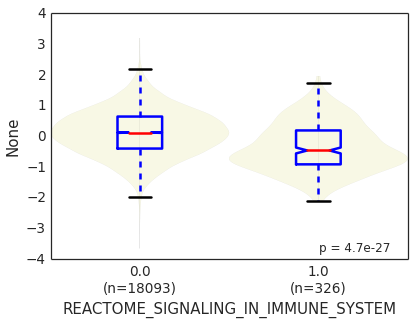

In [26]:
violin_plot_pandas(gs2['REACTOME_SIGNALING_IN_IMMUNE_SYSTEM'], log_odds)

In [27]:
human_net = pd.read_csv('/cellar/users/agross/Data/networks/HumanNet/HumanNet_HUGO.csv',
                        usecols=['gene1','gene2','weight'])

p53_int1 = pd.Series(1, human_net[human_net.gene1 == 'TP53'].gene2).ix[log_odds.index].fillna(0)
p53_int2 = pd.Series(1, human_net[human_net.gene2 == 'TP53'].gene1).ix[log_odds.index].fillna(0)
p53_int = (p53_int1 + p53_int2) > 0

In [29]:
log_odds.order()

RNF125    -3.66
NOSTRIN   -3.14
EDA2R     -2.98
ABCA8     -2.75
ASPA      -2.72
HLF       -2.69
LRRK2     -2.68
RPS27L    -2.63
SPATA18   -2.61
TMEM220   -2.58
MSRA      -2.50
MYOC      -2.42
SDPR      -2.42
TMEM100   -2.40
ACSM1     -2.39
...
CCDC21      2.50
AARS        2.57
KIAA1524    2.57
SALL4       2.67
AURKA       2.69
TCFL5       2.71
FANCB       2.72
MCM8        2.91
UBE2S       2.91
TROAP       2.92
C1orf135    2.93
STIP1       3.00
CEP55       3.11
C20orf20    3.15
KIF14       3.19
Length: 18419, dtype: float64

In [30]:
%time p = df_odds_ratio[log_odds.abs() > 2].apply(fet, 1).order()

CPU times: user 2.19 s, sys: 4.08 ms, total: 2.19 s
Wall time: 2.19 s


In [31]:
lp = (-1 * np.log10(p) * np.sign(log_odds))

In [32]:
v = (log_odds.abs() > 2) * np.sign(log_odds)

In [33]:
sim = screen_feature(v[v.abs() > 0]>0, fisher_exact_test, dr.T)

In [34]:
o = sim.ix[ti(mut.ix['TP53'] == 0)].dropna()

In [35]:
d2 = mut.ix[:, o.index]
d2 = d2[d2.sum(1) > 15]
d2.shape

(369, 362)

In [36]:
rr = screen_feature(lp, rev_kruskal, gs2.T)
rr.head(10)

,H,p,q
REACTOME_GENE_EXPRESSION,146.39,1.07e-33,8.87e-31
REACTOME_DOWNSTREAM_EVENTS_IN_GPCR_SIGNALING,138.98,4.45e-32,1.85e-29
REACTOME_GPCR_LIGAND_BINDING,114.55,9.85e-27,2.73e-24
REACTOME_CELL_CYCLE_MITOTIC,106.10,7.03e-25,1.46e-22
REACTOME_SIGNALING_IN_IMMUNE_SYSTEM,104.17,1.86e-24,3.10e-22
REACTOME_HEMOSTASIS,87.10,1.03e-20,1.43e-18
REACTOME_CLASS_A1_RHODOPSIN_LIKE_RECEPTORS,81.74,1.55e-19,1.85e-17
KEGG_MAPK_SIGNALING_PATHWAY,79.43,5.00e-19,5.20e-17
KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION,76.03,2.79e-18,2.58e-16
KEGG_NEUROACTIVE_LIGAND_RECEPTOR_INTERACTION,73.68,9.18e-18,7.64e-16


In [37]:
proliferation = pd.read_csv('/cellar/users/agross/TCGA_Code/DX/rna_signature.csv',
                            header=None, index_col=[0,1], squeeze=True)

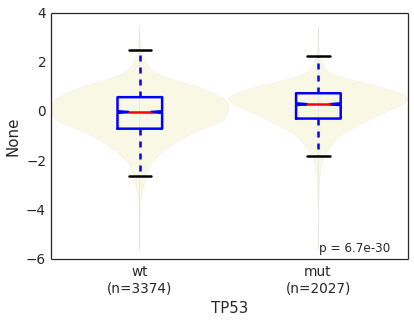

In [38]:
v = proliferation.ix[:, 1].dropna()
v = (v - codes.map(v.groupby(codes).mean())) / codes.map(v.groupby(codes).std())
violin_plot_pandas(p53_mut, v)

In [39]:
cd ../DX/Notebooks/

/cellar/users/agross/TCGA_Code/DX/Notebooks


importing IPython notebook from Immune_Stroma_Scoring

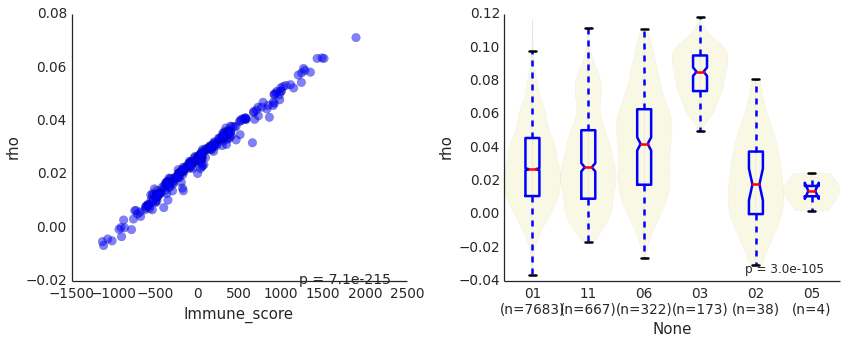

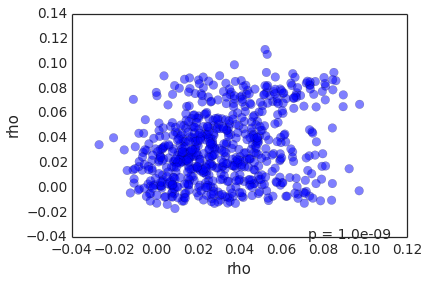

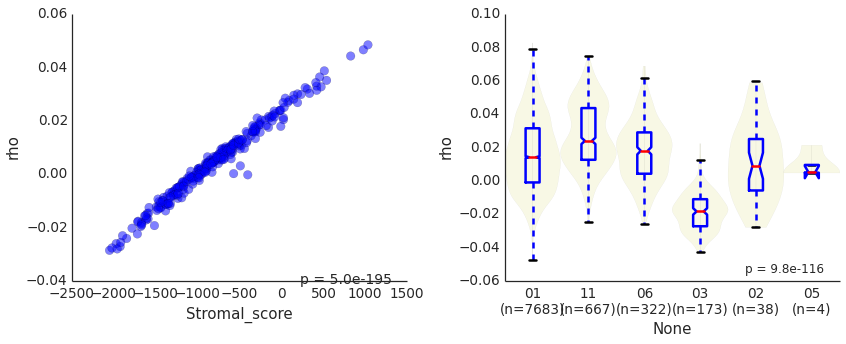

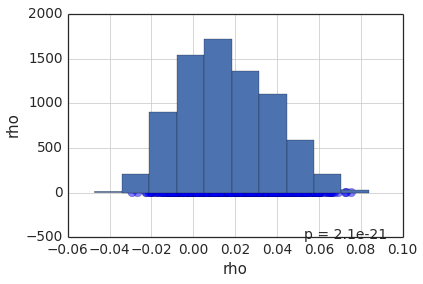

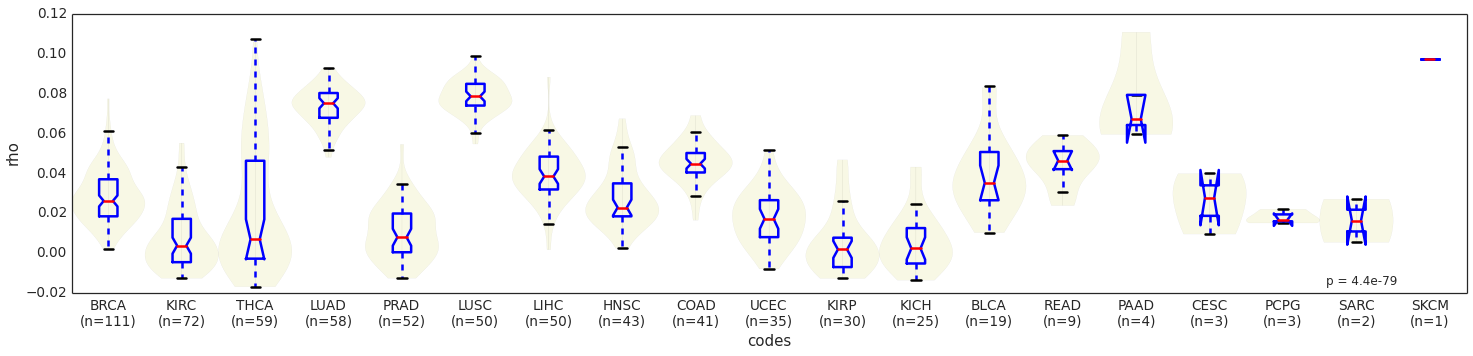

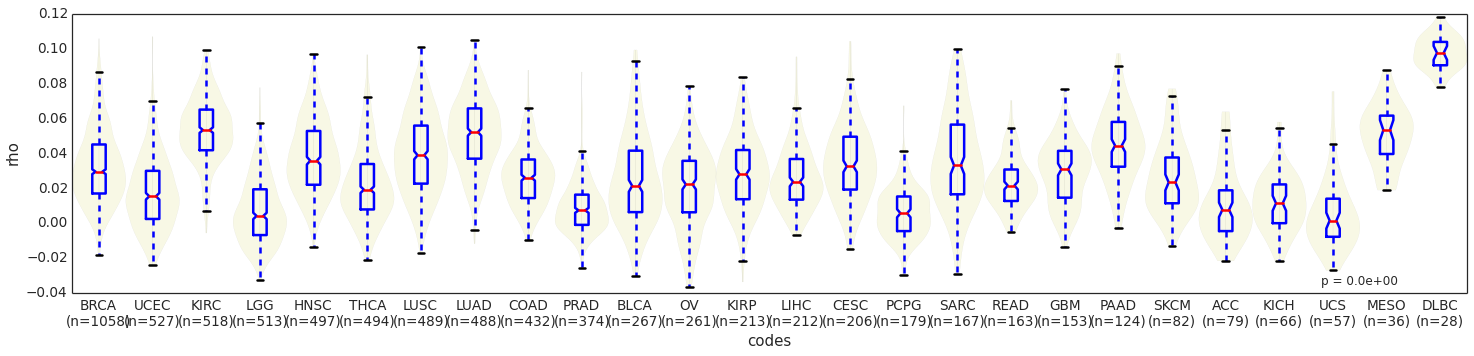

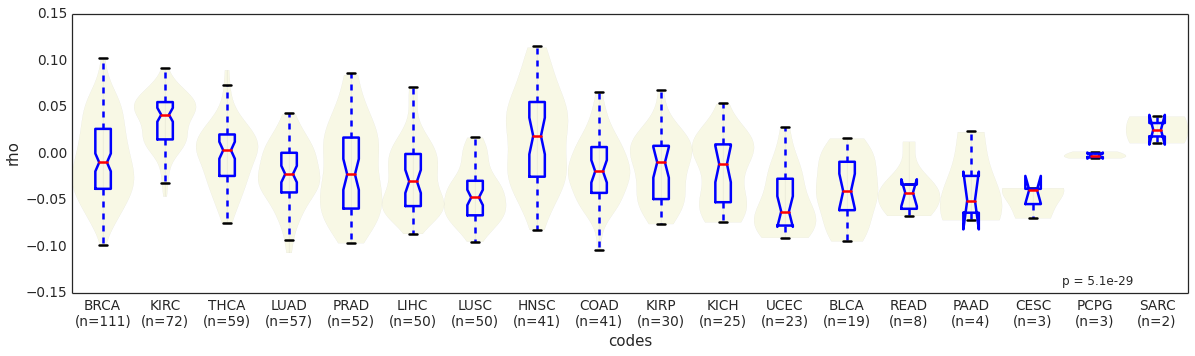

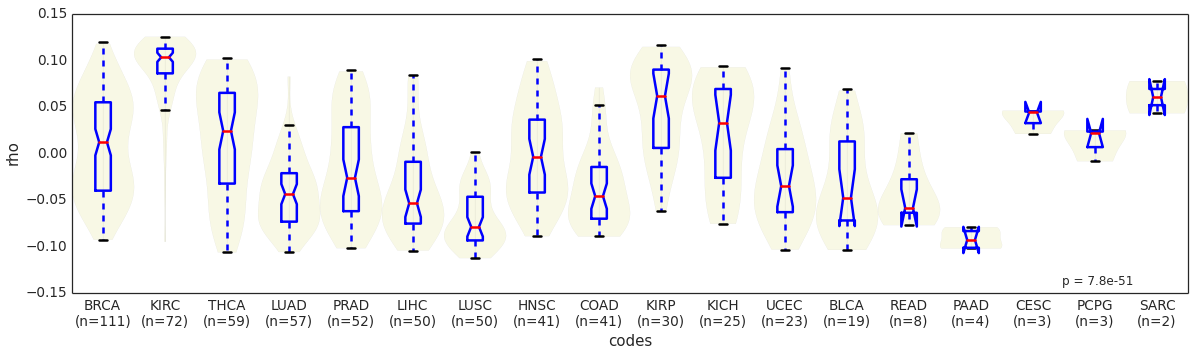

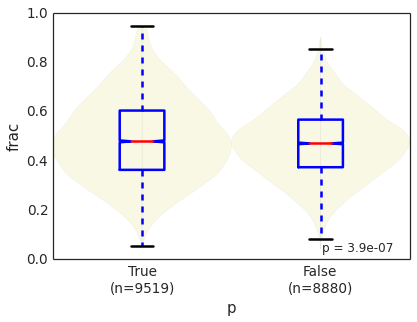

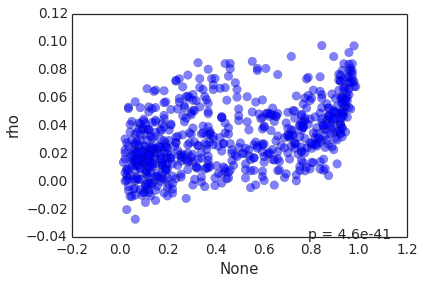

In [40]:
import Immune_Stroma_Scoring as S

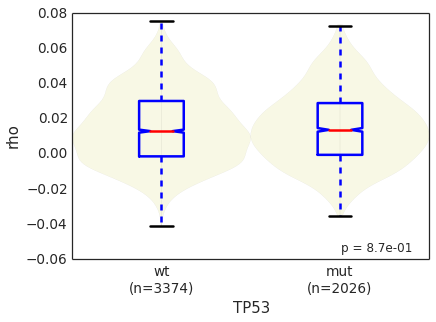

In [41]:
v = S.stromal_score.ix[:, '01']
#v = (v - codes.map(v.groupby(codes).mean())) / codes.map(v.groupby(codes).std())
violin_plot_pandas(p53_mut, v)